In [45]:
from sklearn.datasets import make_circles

n_samples = 100000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.10, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [46]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.7132302  -0.05717016]
 [-0.67322099 -0.44490425]
 [-0.6784056   0.54385209]
 [-0.69265683 -0.09240726]
 [ 0.49494104 -0.73899987]]

First 5 y labels:
[1 1 0 1 1]


In [47]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,-0.713230,-0.057170,1
1,-0.673221,-0.444904,1
2,-0.678406,0.543852,0
3,-0.692657,-0.092407,1
4,0.494941,-0.739000,1
5,-0.866470,0.021345,1
6,-0.186772,-0.685915,1
7,-0.343101,-0.533421,1
8,0.050342,0.638681,1
9,0.675540,0.051023,1


In [48]:
# Check different labels
circles.label.value_counts()

1    50000
0    50000
Name: label, dtype: int64

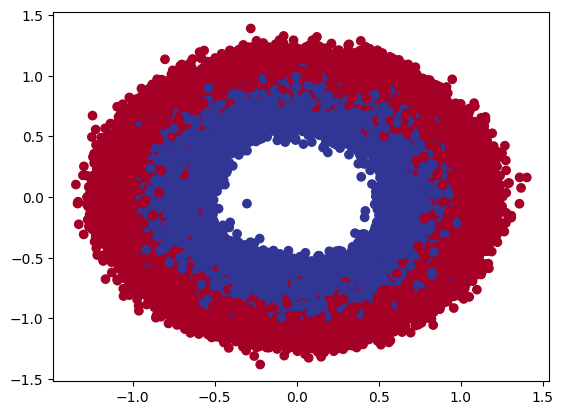

In [49]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [50]:
# Check the shapes of our features and labels
X.shape, y.shape

((100000, 2), (100000,))

In [51]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-0.7132302  -0.05717016] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [52]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.7132, -0.0572],
         [-0.6732, -0.4449],
         [-0.6784,  0.5439],
         [-0.6927, -0.0924],
         [ 0.4949, -0.7390]]),
 tensor([1., 1., 0., 1., 1.]))

In [91]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc
    
def train(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs=100):
    torch.manual_seed(42)

    # Put data to target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Build training and evaluation loop
    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
      
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                       y_train) 
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)

        # Print out what's happening every 1/10 * total epochs
        if epoch % (epochs // 10) == 0: 
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [54]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(80000, 20000, 80000, 20000)

In [35]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Replicate CircleModelV0 with nn.Sequential
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Make predictions with the model
untrained_preds = model_1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.4935],
        [0.2730],
        [0.8670],
        [0.3885],
        [0.5425],
        [0.4104],
        [0.0468],
        [0.0781],
        [0.8801],
        [0.2547]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [17]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[0.4935],
        [0.2730],
        [0.8670],
        [0.3885],
        [0.5425]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6209],
        [0.5678],
        [0.7041],
        [0.5959],
        [0.6324]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [19]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
train(model_0, X_train, y_train, X_test, y_test, loss_fn, optimizer, 100)

Epoch: 0 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 10 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 20 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 30 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 40 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 50 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 60 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 70 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 80 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%
Epoch: 90 | Loss: 0.71223, Accuracy: 50.00% | Test loss: 0.71780, Test acc: 50.00%


In [22]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [32]:
def plot_model(model, X_train, X_test, y_train, y_test):
  # Plot decision boundaries for training and test sets
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.title("Train")
  plot_decision_boundary(model, X_train, y_train)
  plt.subplot(1, 2, 2)
  plt.title("Test")
  plot_decision_boundary(model, X_test, y_test)

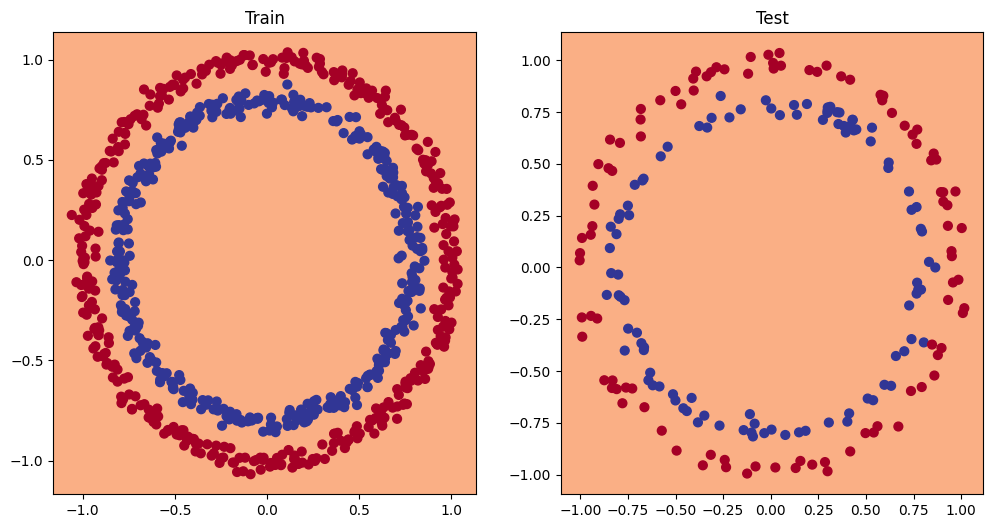

In [33]:
plot_model(model_0, X_train, X_test, y_train, y_test)

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): 
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
train(model_1, X_train, y_train, X_test, y_test, loss_fn, optimizer, 1000)

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%


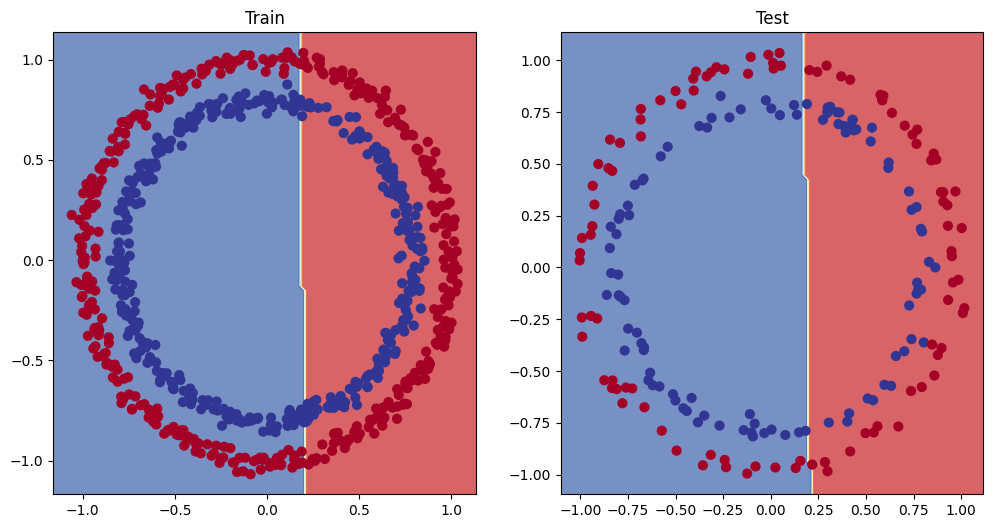

In [34]:
plot_model(model_1, X_train, X_test, y_train, y_test)

In [31]:
# Build a model with non linear activation function

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.activation_1 = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.activation_1(x)
    x = self.layer_2(x)
    x = self.activation_1(x)
    x = self.layer_3(x)
    return x

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69329, Test acc: 50.00%
Epoch: 500 | Loss: 0.68126, Accuracy: 53.62% | Test loss: 0.68084, Test acc: 56.00%
Epoch: 1000 | Loss: 0.57644, Accuracy: 84.62% | Test loss: 0.58984, Test acc: 84.00%
Epoch: 1500 | Loss: 0.17569, Accuracy: 97.38% | Test loss: 0.26558, Test acc: 91.00%
Epoch: 2000 | Loss: 0.08736, Accuracy: 98.25% | Test loss: 0.17344, Test acc: 93.50%
Epoch: 2500 | Loss: 0.06655, Accuracy: 98.38% | Test loss: 0.15167, Test acc: 93.50%
Epoch: 3000 | Loss: 0.05835, Accuracy: 98.50% | Test loss: 0.14531, Test acc: 94.00%
Epoch: 3500 | Loss: 0.05400, Accuracy: 98.62% | Test loss: 0.14316, Test acc: 94.00%
Epoch: 4000 | Loss: 0.05133, Accuracy: 98.50% | Test loss: 0.14269, Test acc: 93.50%
Epoch: 4500 | Loss: 0.04956, Accuracy: 98.75% | Test loss: 0.14208, Test acc: 93.00%


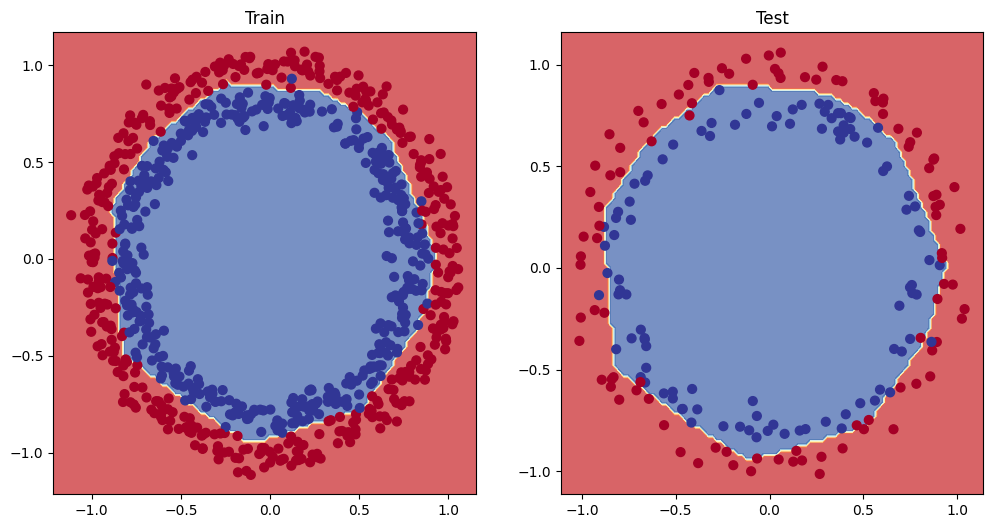

In [69]:
import torch
from sklearn.datasets import make_circles

n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_2 = CircleModelV2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

train(model_2, X_train, y_train, X_test, y_test, loss_fn, optimizer, 5000)

plot_model(model_2, X_train, X_test, y_train, y_test)

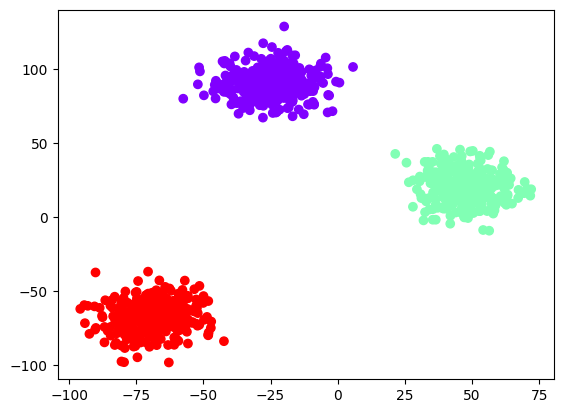

In [136]:
# Multi-class classification

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_samples = 1000
n_centers = 3

# Create blobs
X, y = make_blobs(n_samples=n_samples,
                  centers=n_centers,
                  cluster_std=10,
                  center_box=(-100.0, 100.0),
                  random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow")
plt.show()

In [149]:
class MulticlassClassificationModel(nn.Module):
  def __init__(self, n_centers: int):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10),
        nn.Sigmoid(),
        nn.Linear(in_features=10, out_features=10),
        nn.Tanh(),
        nn.Linear(in_features=10, out_features=10),
        nn.LeakyReLU(),
        nn.Linear(in_features=10, out_features=n_centers)
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

In [154]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_3 = MulticlassClassificationModel(n_centers).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [153]:
def train_multiclass(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs=100):
    torch.manual_seed(42)

    # Put data to target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Build training and evaluation loop
    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train) # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labls
      
        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                       y_train) 
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)

        # Print out what's happening every 1/10 * total epochs
        if epoch % (epochs // 10) == 0: 
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.12110, Accuracy: 32.25% | Test loss: 1.07529, Test acc: 37.50%
Epoch: 100 | Loss: 0.04607, Accuracy: 100.00% | Test loss: 0.04367, Test acc: 100.00%
Epoch: 200 | Loss: 0.01008, Accuracy: 100.00% | Test loss: 0.00976, Test acc: 100.00%
Epoch: 300 | Loss: 0.00501, Accuracy: 100.00% | Test loss: 0.00488, Test acc: 100.00%
Epoch: 400 | Loss: 0.00320, Accuracy: 100.00% | Test loss: 0.00312, Test acc: 100.00%
Epoch: 500 | Loss: 0.00230, Accuracy: 100.00% | Test loss: 0.00225, Test acc: 100.00%
Epoch: 600 | Loss: 0.00178, Accuracy: 100.00% | Test loss: 0.00174, Test acc: 100.00%
Epoch: 700 | Loss: 0.00144, Accuracy: 100.00% | Test loss: 0.00141, Test acc: 100.00%
Epoch: 800 | Loss: 0.00120, Accuracy: 100.00% | Test loss: 0.00118, Test acc: 100.00%
Epoch: 900 | Loss: 0.00103, Accuracy: 100.00% | Test loss: 0.00101, Test acc: 100.00%


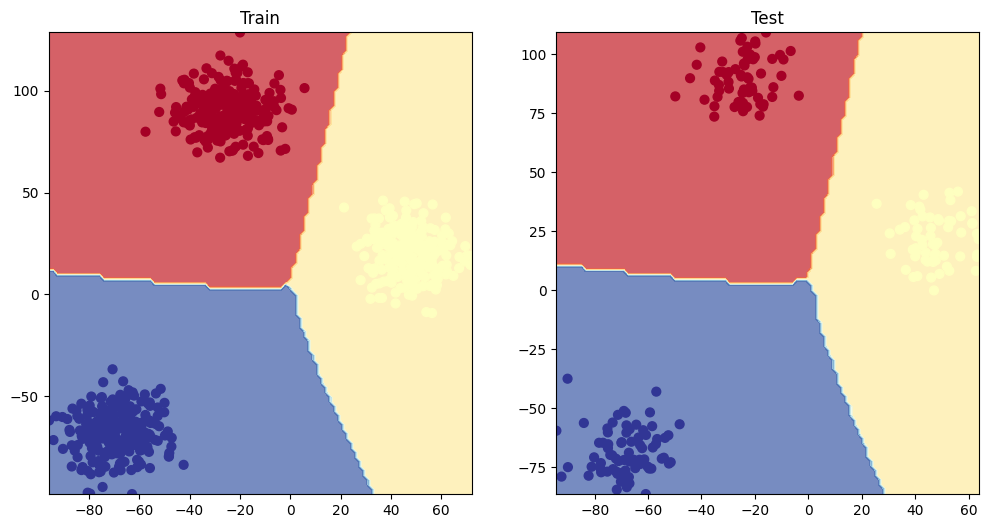

In [151]:
train_multiclass(model_3, X_train, y_train, X_test, y_test, loss, optimizer, 1000)

plot_model(model_3, X_train, X_test, y_train, y_test)

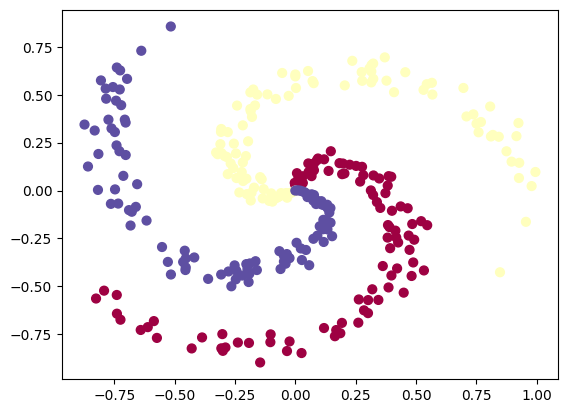

In [152]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

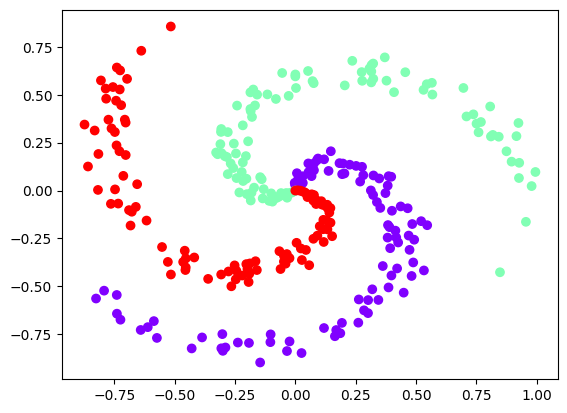

In [155]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow")
plt.show()

In [185]:
class SpiralClassificationModel(nn.Module):
  def __init__(self, n_centers: int):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=n_centers)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

In [186]:
device = "cuda" if torch.cuda.is_available() else "cpu"
n_centers = 3
model_4 = SpiralClassificationModel(n_centers).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

Epoch: 0 | Loss: 1.11749, Accuracy: 32.50% | Test loss: 1.10939, Test acc: 36.67%
Epoch: 1000 | Loss: 0.59402, Accuracy: 66.67% | Test loss: 0.64571, Test acc: 63.33%
Epoch: 2000 | Loss: 0.32639, Accuracy: 86.67% | Test loss: 0.37166, Test acc: 85.00%
Epoch: 3000 | Loss: 0.11365, Accuracy: 96.25% | Test loss: 0.09163, Test acc: 98.33%
Epoch: 4000 | Loss: 0.05977, Accuracy: 98.33% | Test loss: 0.04245, Test acc: 100.00%
Epoch: 5000 | Loss: 0.04608, Accuracy: 99.17% | Test loss: 0.02459, Test acc: 100.00%
Epoch: 6000 | Loss: 0.03894, Accuracy: 99.17% | Test loss: 0.01693, Test acc: 100.00%
Epoch: 7000 | Loss: 0.03464, Accuracy: 99.17% | Test loss: 0.01312, Test acc: 100.00%
Epoch: 8000 | Loss: 0.03164, Accuracy: 99.17% | Test loss: 0.01090, Test acc: 100.00%
Epoch: 9000 | Loss: 0.02937, Accuracy: 99.17% | Test loss: 0.00955, Test acc: 100.00%


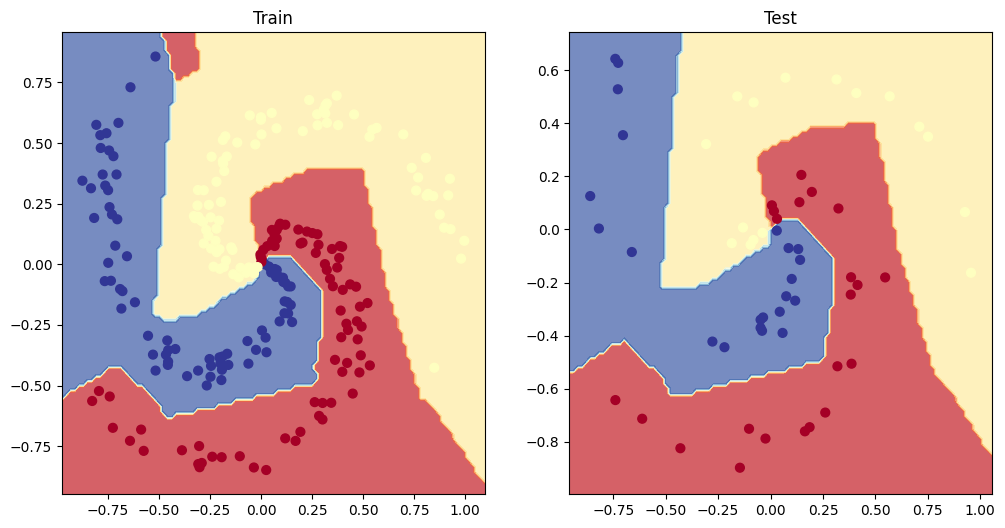

In [187]:
train_multiclass(model_4, X_train, y_train, X_test, y_test, loss, optimizer, 10000)

plot_model(model_4, X_train, X_test, y_train, y_test)